# <center> WASC calibration </center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.pyplot import figure
from importlib import reload
import sys
import src.Wishart.WASC
reload(src.Wishart.WASC)
from src.Wishart.WASC import calibrate_wasc, ModelParameters
from src.utils import process_data, round_params
import datetime
import warnings
warnings.filterwarnings("ignore")
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [2]:
%%time
raw = pd.HDFStore('datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()
# raw.dt.hist(bins = 100)

CPU times: user 21.1 s, sys: 3.02 s, total: 24.1 s
Wall time: 25.5 s


In [3]:
%%time
df = process_data(raw)
df.head()

CPU times: user 21.1 s, sys: 3.12 s, total: 24.2 s
Wall time: 25.4 s


,instrument,dt,mark_price,type,strike_price,expiration,underlying_price,timestamp,tau,mark_price_usd
1,ETH-10FEB23-1000-P,2023-01-27 07:45:00,0.0010,put,1000,1675987200000000,1581.733579,1674805500000000,0.037471,1.581734
3,ETH-10FEB23-1100-P,2023-01-27 07:45:00,0.0015,put,1100,1675987200000000,1581.733579,1674805500000000,0.037471,2.372600
5,ETH-10FEB23-1150-P,2023-01-27 07:45:00,0.0020,put,1150,1675987200000000,1581.733579,1674805500000000,0.037471,3.163467
7,ETH-10FEB23-1200-P,2023-01-27 07:45:00,0.0025,put,1200,1675987200000000,1581.733579,1674805500000000,0.037471,3.954334
9,ETH-10FEB23-1250-P,2023-01-27 07:45:00,0.0035,put,1250,1675987200000000,1581.733579,1674805500000000,0.037471,5.536068


# Params dynamics

In [268]:
%%time
number_of_dots = 300
timestamps_hm = []

params_all = []
errors_all = []

Q11, Q12, Q21, Q22, E11, Ed, E22, R11, R12, R21, R22 = 0.3417, 0.3493, 0.1848, 0.3090, 0.0298, 0.0119, 0.0108, -1.2479, -0.8985, -0.0820, -1.1433
start_params = np.array([Q11, Q12, Q21, Q22, E11, Ed, E22, R11, R12, R21, R22])

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 23:00:00")].copy()
df_only_exp = calibr_borders[calibr_borders["expiration"] == calibr_borders.sample(1).expiration.iloc[0]].copy()

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, first_res  = calibrate_wasc(df = df_only_exp, 
                                                        start_params = start_params)


print("All first calibrated:", round_params(calibrated_params_all), "error:", first_error_all)
timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
            # zero params for each point are params from last step
        calibrated_params_all, error_all, _  = calibrate_wasc(df = df_only_exp, start_params = calibrated_params_all, 
                                    timestamp = timestamp)
        # print("All calibrated:", round_params(calibrated_params_all), "error:", error_all)


        params_all.append(calibrated_params_all)
        errors_all.append(error_all)
        timestamps_hm.append(timestamp)
    except:
        # print("Error!")
        calibrated_params_all = start_params
        # print("    ")

timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T





Optimize first params with random start once
All first calibrated: [0.44, 0.809, 0.075, 0.344, 0.166, -0.304, 0.131, -0.899, -3.748, -0.482, -1.347] error: 0.029837312432591655


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 4min 30s, sys: 2min 31s, total: 7min 2s
Wall time: 57.1 s


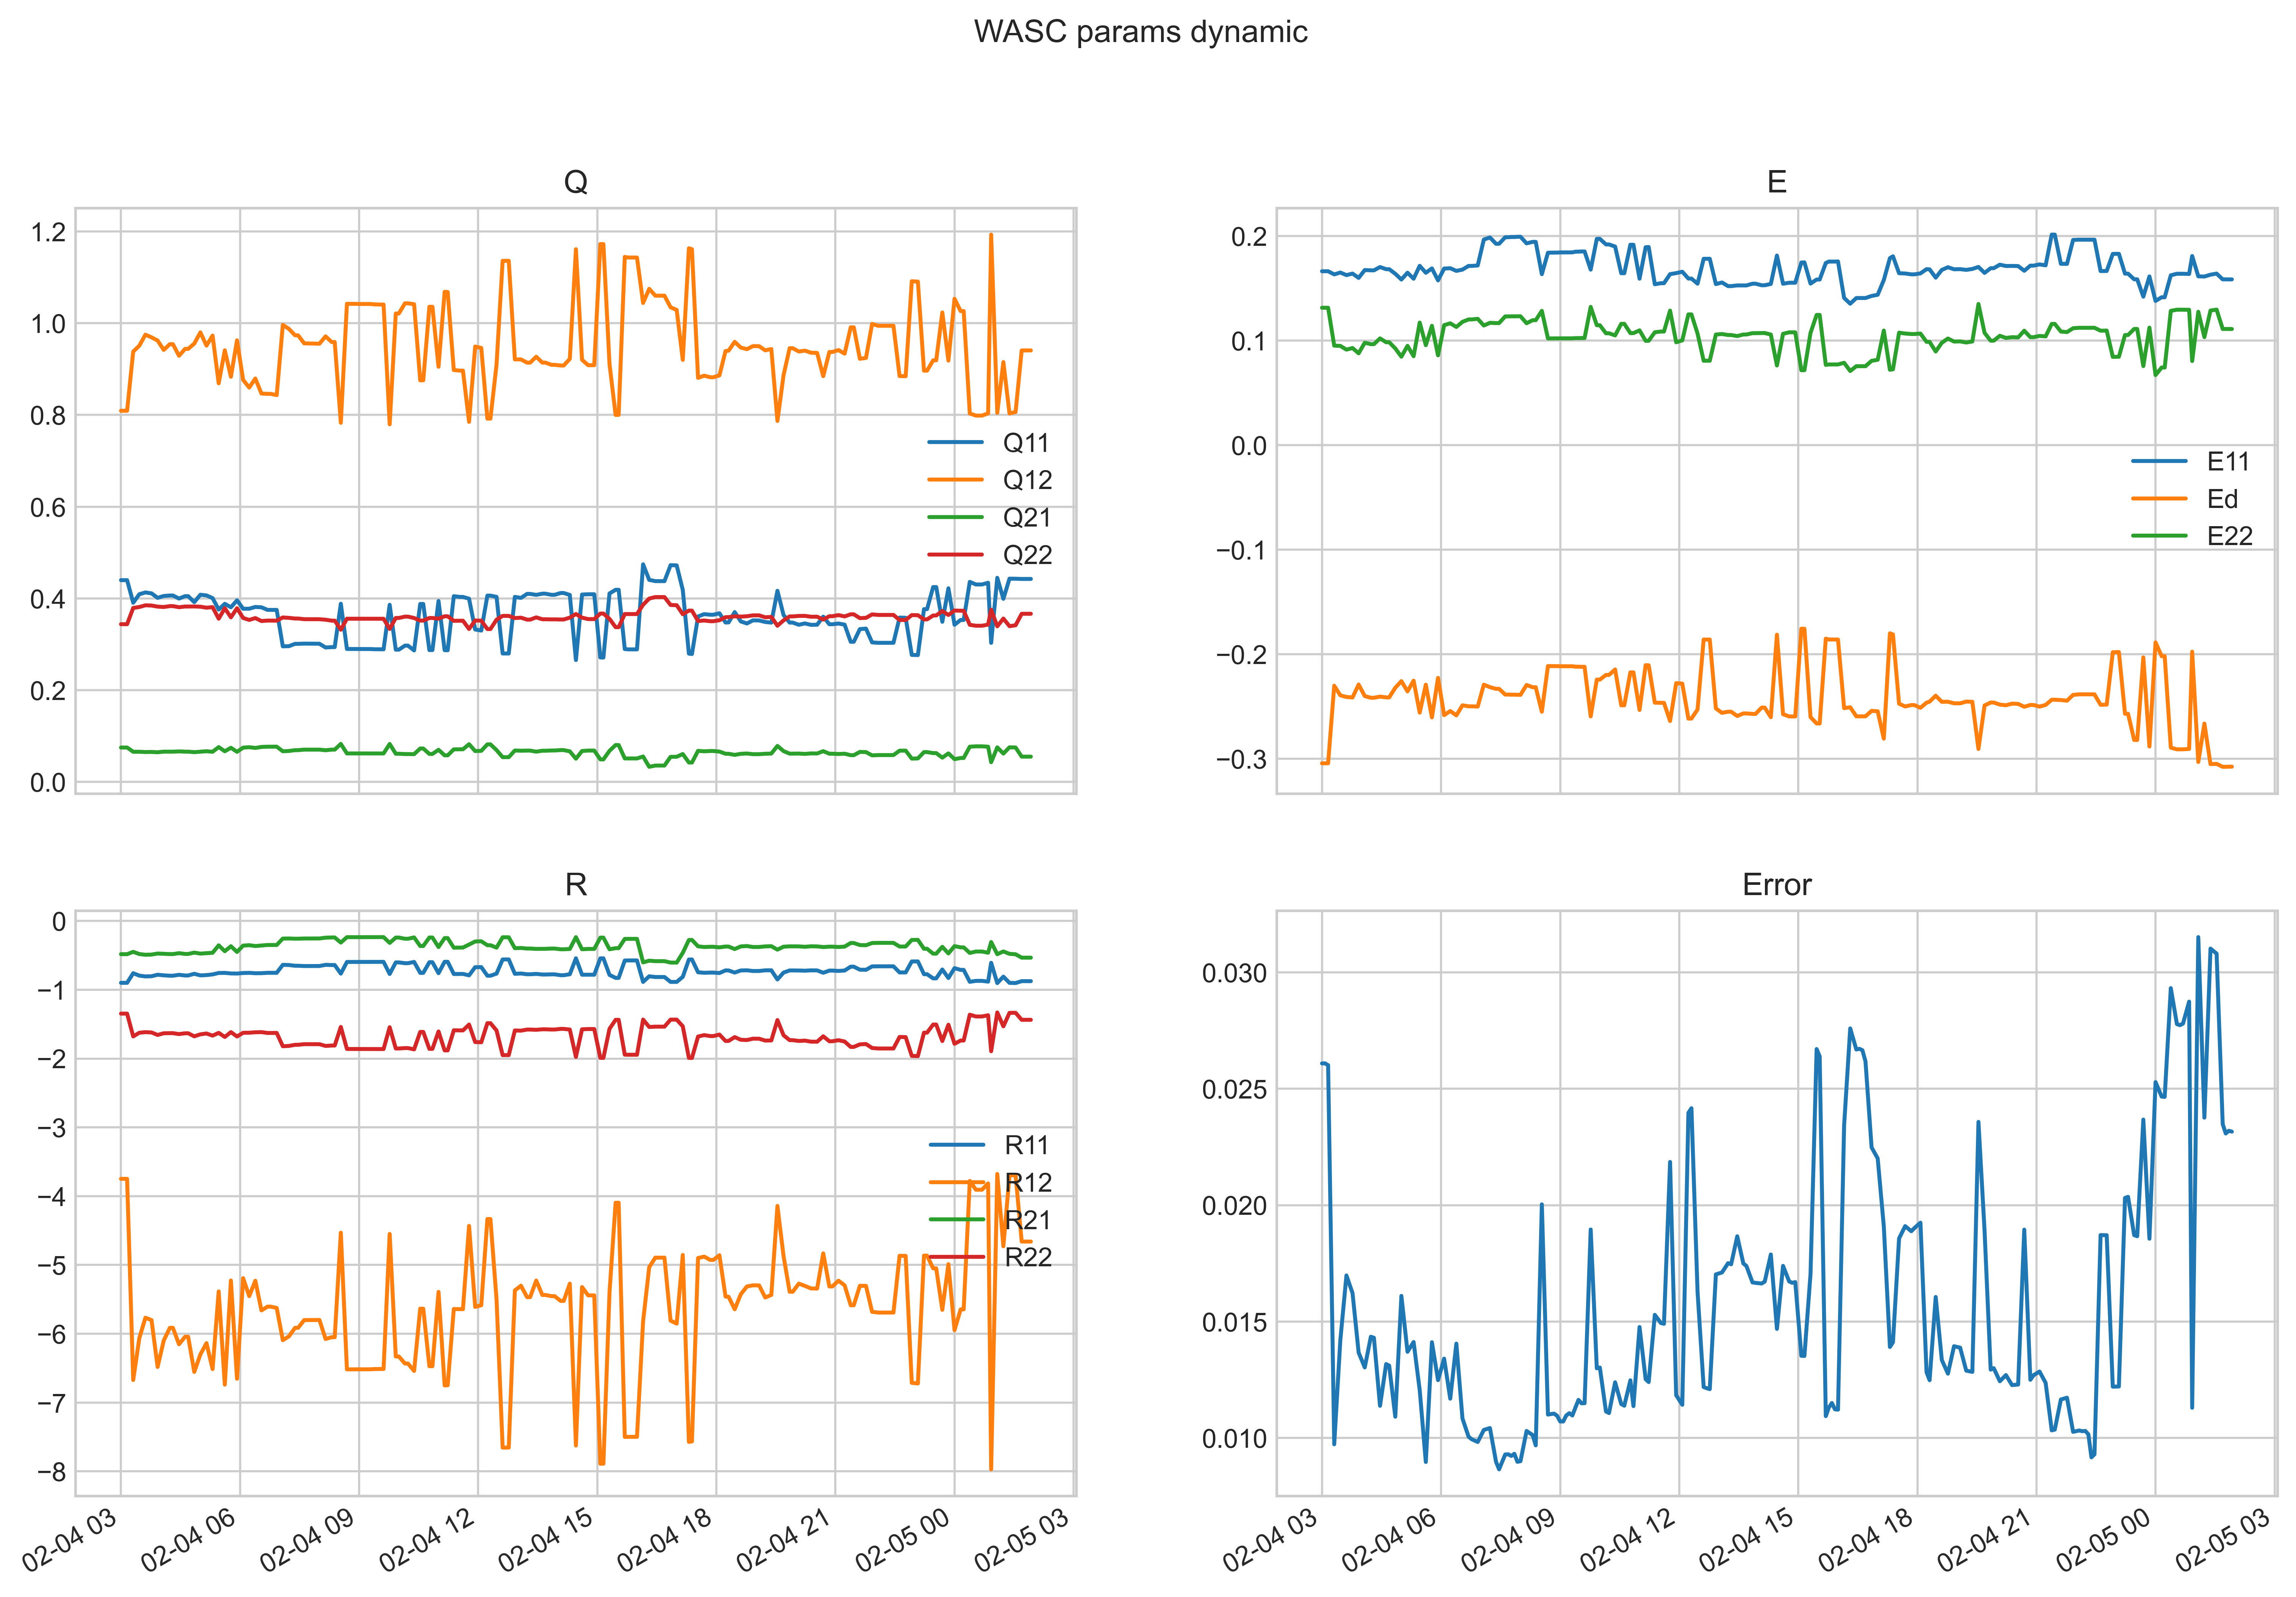

In [221]:
fig, axs =  plt.subplots(nrows=2, ncols=2, figsize=(15, 10), dpi = 500)

axs[0, 0].plot(timestamps_hm, params_all[0], label = "Q11")
axs[0, 0].plot(timestamps_hm, params_all[1], label = "Q12")
axs[0, 0].plot(timestamps_hm, params_all[2], label = "Q21")
axs[0, 0].plot(timestamps_hm, params_all[3], label = "Q22")
axs[0, 0].legend(loc="right")

axs[0, 1].plot(timestamps_hm, params_all[4], label = "E11")
axs[0, 1].plot(timestamps_hm, params_all[5], label = "Ed")
axs[0, 1].plot(timestamps_hm, params_all[6], label = "E22")
axs[0, 1].legend(loc="right")

axs[1, 0].plot(timestamps_hm, params_all[7], label = "R11")
axs[1, 0].plot(timestamps_hm, params_all[8], label = "R12")
axs[1, 0].plot(timestamps_hm, params_all[9], label = "R21")
axs[1, 0].plot(timestamps_hm, params_all[10], label = "R22")
axs[1, 0].legend(loc="right")

axs[1, 1].plot(timestamps_hm, errors_all, label = "R22")


axs[0, 0].set_title(r"Q")
axs[0, 1].set_title(r"E")
axs[1, 0].set_title(r"R")
axs[1, 1].set_title(r"Error")



# plt.figlegend() 
fig.suptitle("WASC params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Volatility smile

All:
[0.35, 1.001, 0.07, 0.387, 0.204, -0.258, 0.133, -0.717, -5.96, -0.355, -1.804]
0.00622242920185832
   


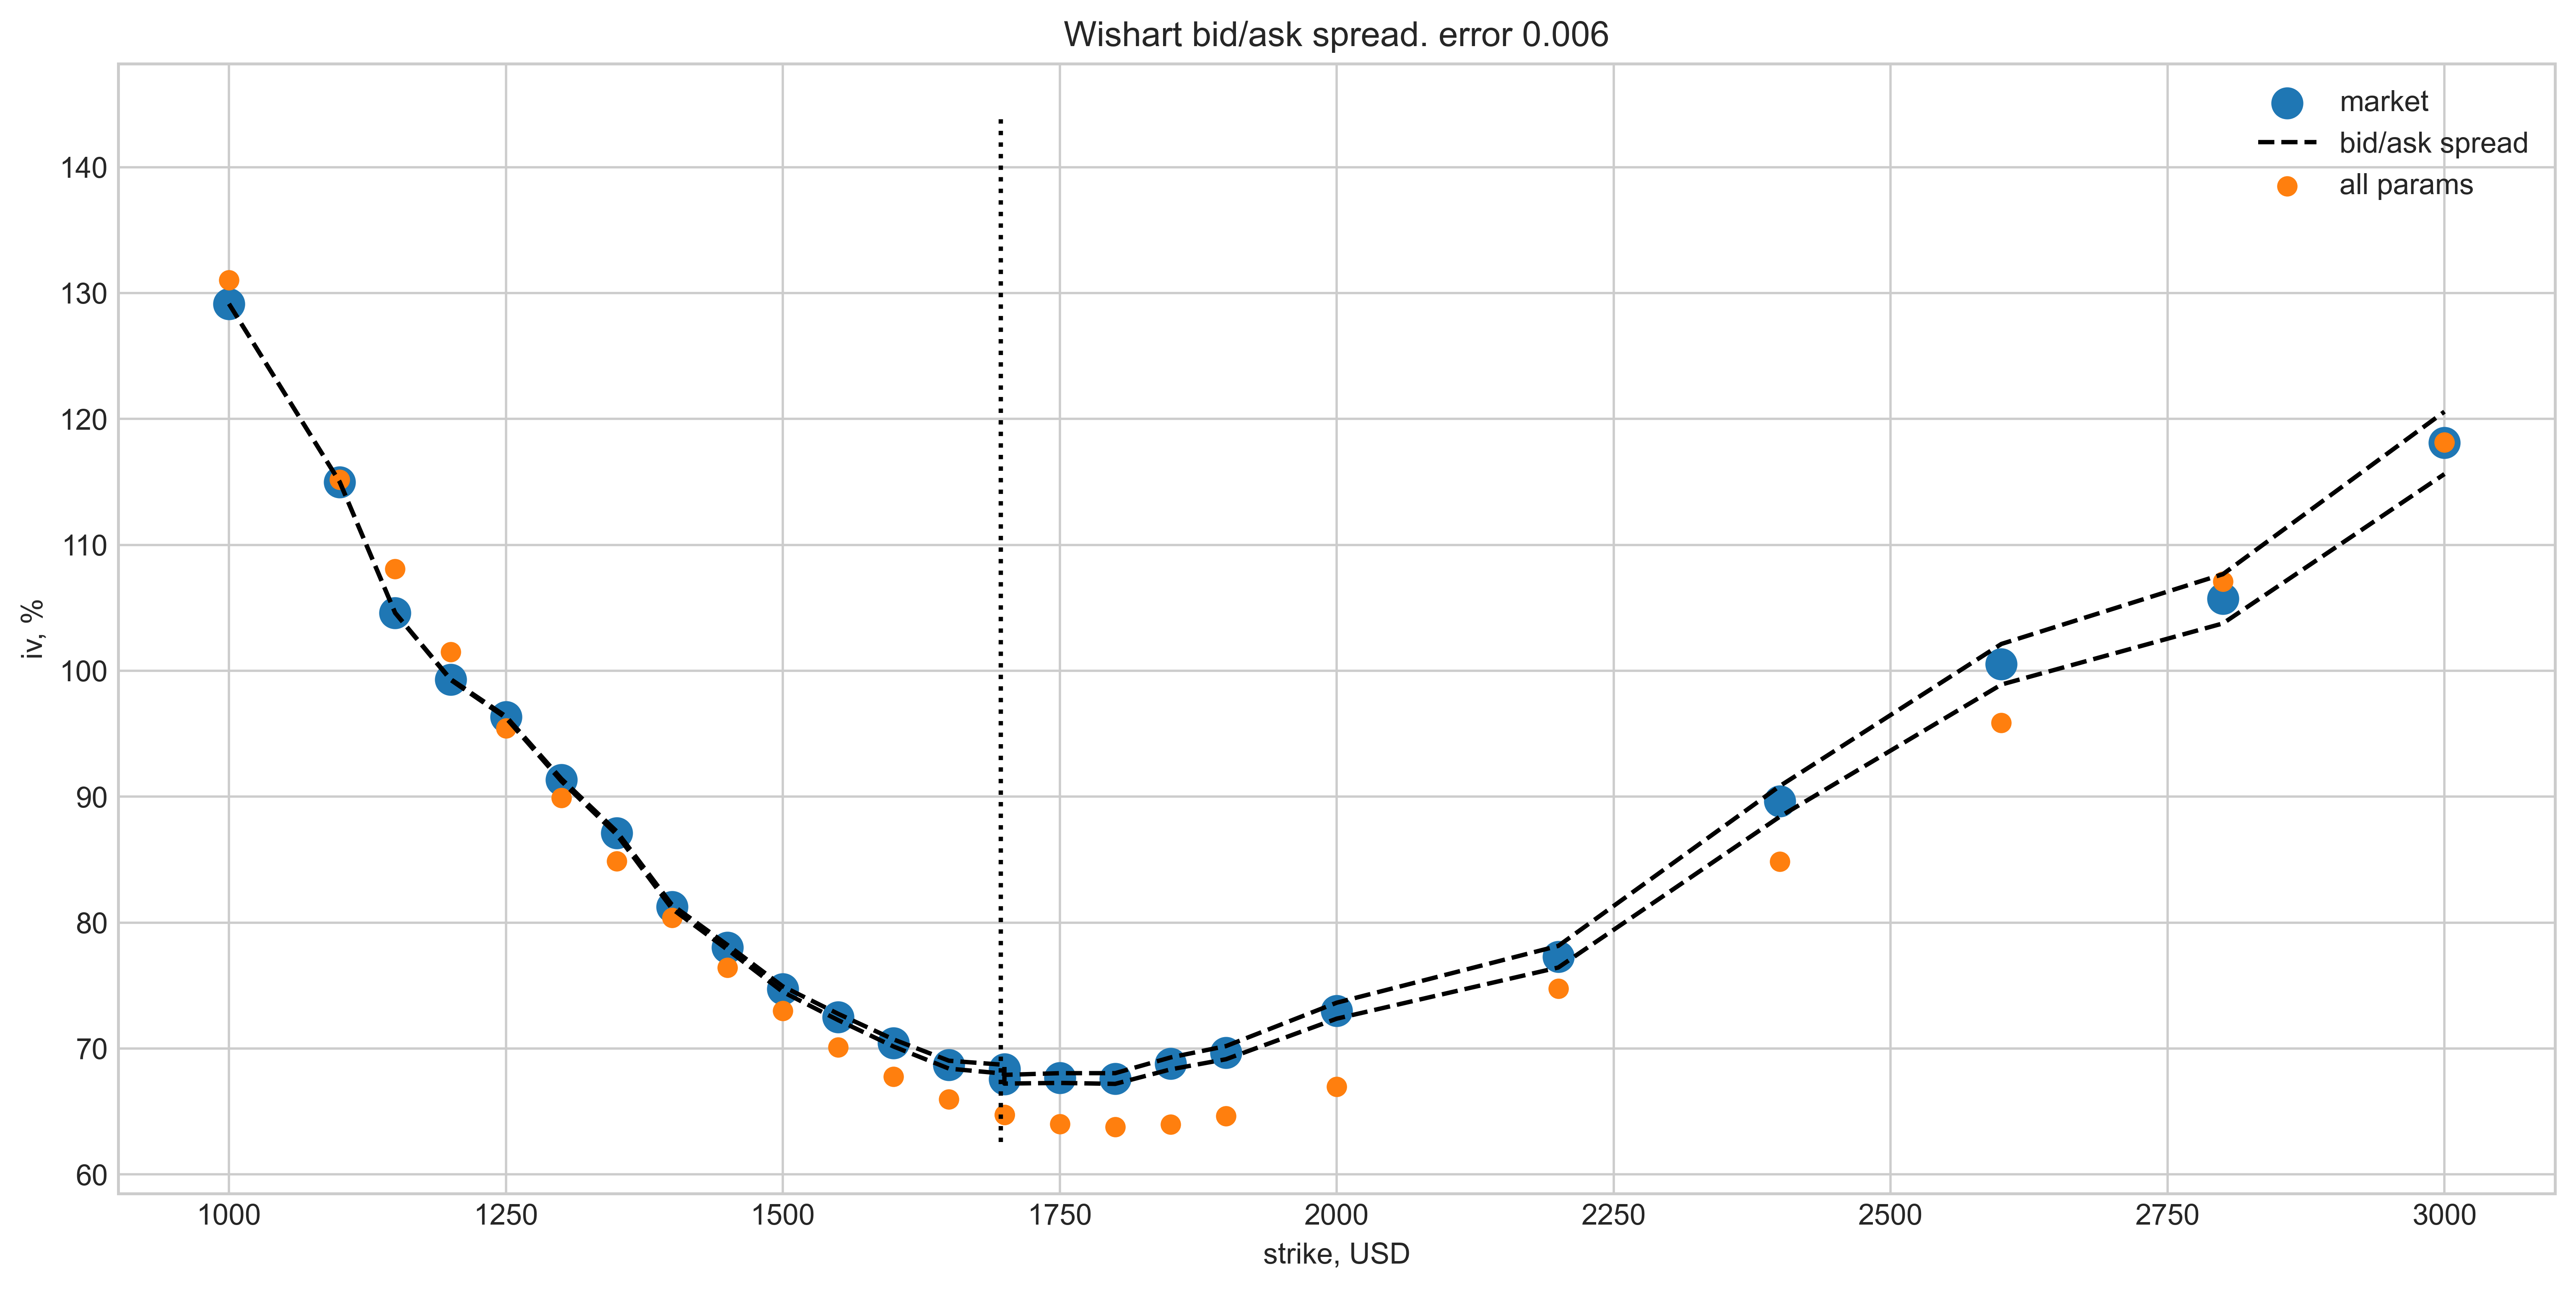

In [267]:
df_only_exp = df[df["expiration"] == df.sample(1).expiration.iloc[0]].copy()
needed_stamp = df_only_exp.sample(1).iloc[0].timestamp

Q11, Q12, Q21, Q22, E11, Ed, E22, R11, R12, R21, R22 = 0.3417, 0.3493, 0.1848, 0.3090, 0.0298, 0.0119, 0.0108, -1.2479, -0.8985, -0.0820, -1.1433
start_params = np.array([Q11, Q12, Q21, Q22, E11, Ed, E22, R11, R12, R21, R22])

pars_all, err_all, C_all = calibrate_wasc(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,)



print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")



figure(figsize=(15, 7), dpi=500)
C_all = C_all.sort_values("strike_price")
plt.scatter(C_all["strike_price"], C_all["iv"], label = "market", linewidths = 5)

# bid,ask iv
plt.plot(C_all["strike_price"], C_all["ask_iv"], '--', label = "bid/ask spread", color = "black")
plt.plot(C_all["strike_price"], C_all["bid_iv"], '--', color = "black")

plt.scatter(C_all["strike_price"], C_all["calibrated_iv"], label = "all params")


plt.vlines([C_all.underlying_price.mean()], C_all.iv.min() - 5, 
           C_all.iv.max() + 15, color = "black", linestyles = "dotted")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.title(f"Wishart bid/ask spread. error {round(err_all, 3)}", )
plt.legend()
plt.show()